In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houseprice/hprice.csv


Found file at: /kaggle/input/houseprice/hprice.csv
Model Performance:
Linear Regression: RMSE = 1324506.96, R² = 0.65
Decision Tree: RMSE = 1625669.90, R² = 0.48


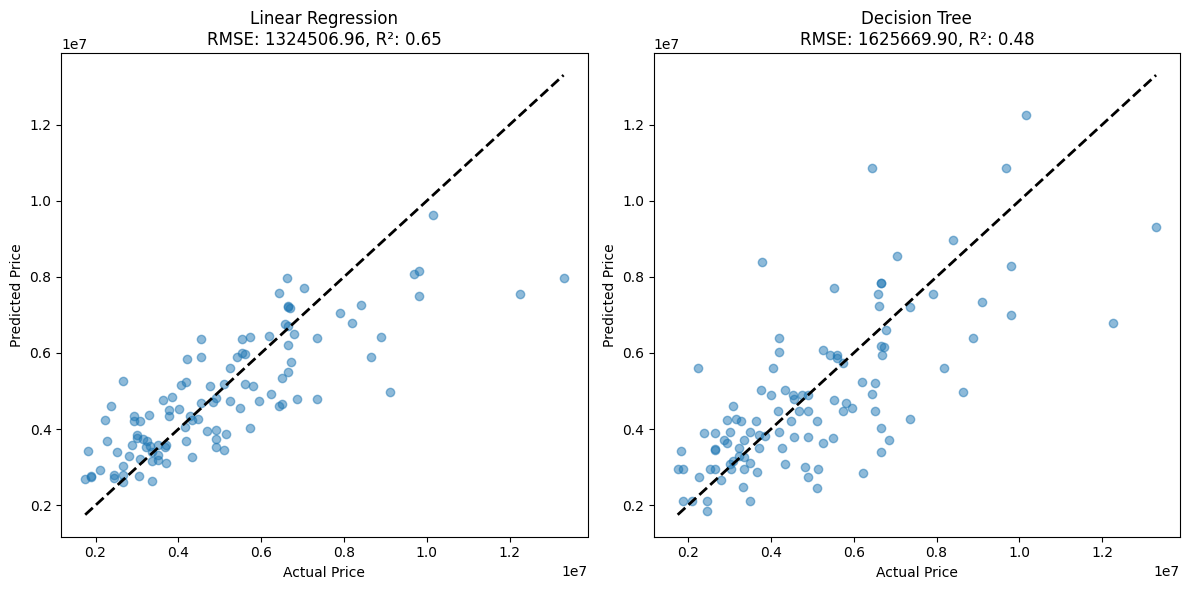

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data():
    """Load the house price data from various possible locations"""
    # First try to find the correct path automatically
    for dirname, _, filenames in os.walk('/kaggle/input'):
        if 'hprice.csv' in filenames:
            correct_path = os.path.join(dirname, 'hprice.csv')
            print(f"Found file at: {correct_path}")
            return pd.read_csv(correct_path)
    
    # If automatic detection fails, try common paths
    common_paths = [
        '/kaggle/input/house-price-dataset/hprice.csv',
        '/kaggle/input/house-prices-advanced-regression-techniques/hprice.csv',
        '/kaggle/input/hprice.csv',
        'hprice.csv'
    ]
    
    for path in common_paths:
        try:
            return pd.read_csv(path)
        except FileNotFoundError:
            continue
    
    raise FileNotFoundError(
        "Could not find hprice.csv. Please ensure: \n"
        "1. The file is uploaded to Kaggle\n"
        "2. Check the correct path in the Kaggle file browser\n"
        "3. The filename is exactly 'hprice.csv' (case sensitive)"
    )

def preprocess_data(df):
    """Preprocess the house price data"""
    # Convert yes/no to 1/0
    binary_cols = ['mainroad', 'guestroom', 'basement', 
                   'hotwaterheating', 'airconditioning', 'prefarea']
    df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))
    
    # One-hot encode furnishingstatus
    df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
    
    return df

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate both regression models"""
    # Initialize models
    lr = LinearRegression()
    dt = DecisionTreeRegressor(random_state=42)
    
    # Train models
    lr.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    
    # Evaluate models
    def evaluate(model, X, y):
        y_pred = model.predict(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        return rmse, r2
    
    lr_rmse, lr_r2 = evaluate(lr, X_test, y_test)
    dt_rmse, dt_r2 = evaluate(dt, X_test, y_test)
    
    return {
        'Linear Regression': {'model': lr, 'rmse': lr_rmse, 'r2': lr_r2},
        'Decision Tree': {'model': dt, 'rmse': dt_rmse, 'r2': dt_r2}
    }

def main():
    """Main execution function"""
    # Load and preprocess data
    data = load_data()
    processed_data = preprocess_data(data.copy())
    
    # Split data
    X = processed_data.drop('price', axis=1)
    y = processed_data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train and evaluate models
    models = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    # Display results
    print("Model Performance:")
    for name, metrics in models.items():
        print(f"{name}: RMSE = {metrics['rmse']:.2f}, R² = {metrics['r2']:.2f}")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    for i, (name, metrics) in enumerate(models.items()):
        plt.subplot(1, 2, i+1)
        y_pred = metrics['model'].predict(X_test)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title(f'{name}\nRMSE: {metrics["rmse"]:.2f}, R²: {metrics["r2"]:.2f}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()